In [84]:
import random
from collections import defaultdict
import numpy as np
from scipy.stats import norm

class Environment:
    def __init__(self, number_of_levers):
        self.number_of_levers = number_of_levers
        self.lever_rewards = [random.randint(0, 50) for _ in range(number_of_levers)]
        self.actions_hist = defaultdict(lambda: 0)
    def take_action(self, lever):
        self.actions_hist[lever] += 1
        expected_reward = self.lever_rewards[lever]
        actual_reward = norm(expected_reward, 2).rvs()
        return actual_reward
    def possible_actions(self):
        return list(range(self.number_of_levers))

class MeanEstimator:
    def __init__(self, default_value):
        self.default_value = default_value
        self.n = 0
        self.mean = default_value
    def value(self):
        return self.mean
    def update(self, sample):
        self.mean = (self.n * self.mean + sample) / (self.n + 1)
        self.n += 1
    
class ValueFunction:
    def __init__(self):
        self.value_estimates = defaultdict(lambda: MeanEstimator(25))
    def update(self, lever, reward):
        estimator = self.value_estimates[lever]
        estimator.update(reward)
    def estimated_value(self, lever):
        return self.value_estimates[lever].value()
    
class Agent:
    def __init__(self, environment, exploit_probability):
        self.environment = environment
        self.exploit_probability = exploit_probability
        self.value_function = ValueFunction()
    def run(self, number_of_tries):
        rewards = np.empty(number_of_tries)
        for i in range(number_of_tries):
            rewards[i] = self.step()
        return rewards
    def step(self):
        if random.random() < self.exploit_probability:
            return self.exploit()
        else:
            return self.explore()
    def exploit(self):
        best_estimated_value = -1
        best_action = None
        
        for action in self.environment.possible_actions():
            estimated_value = self.value_function.estimated_value(action)
            
            if estimated_value > best_estimated_value:
                best_estimated_value = estimated_value
                best_action = action
        
        reward = self.environment.take_action(best_action)
        self.value_function.update(best_action, reward)
        return reward
    def explore(self):
        random_action = random.choice(self.environment.possible_actions())
        reward = self.environment.take_action(random_action)
        self.value_function.update(random_action, reward)
        return reward

In [114]:
environment = Environment(30)
agent = Agent(environment, 0.95)

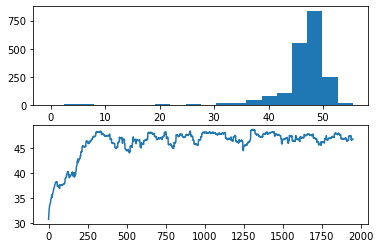

In [115]:
from matplotlib import pyplot as plt
number_of_trials = 2000
rewards = agent.run(number_of_trials)
fig, axes = plt.subplots(2)
axes[0].hist(rewards, bins=20)
window_size = 50
filtered_rewards = np.convolve(rewards, np.ones(window_size) / window_size, 'valid')
axes[1].plot(filtered_rewards)

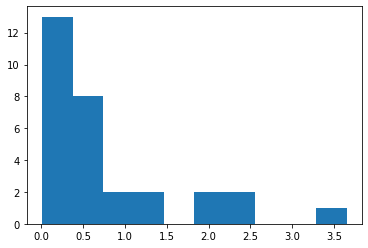

In [116]:
estimation_errors = [abs(agent.value_function.estimated_value(lever) - environment.lever_rewards[lever])
                     for lever in range(environment.number_of_levers)]
plt.figure()
plt.hist(estimation_errors)
plt.show()

In [117]:
np.mean(estimation_errors)

0.7917968106484923

<BarContainer object of 30 artists>

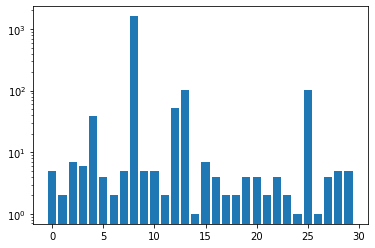

In [118]:
plt.bar(environment.actions_hist.keys(), environment.actions_hist.values(), log=10)